In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transform for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

# Load the dataset JSON file
with open('/workspaces/finetune/AFINAL/resnet/output/train_data.json', 'r') as f:
    dataset = json.load(f)

# Dictionary to map class labels to image paths
class_to_images = {}
for item in dataset:
    cls = item['class']
    if cls not in class_to_images:
        class_to_images[cls] = []
    class_to_images[cls].append(item['image_path'])

In [3]:
class_to_images

{'3000000033': ['/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033_original_3000000033(1).jpg_7c870b02-71dd-4821-826c-8b00dbd02661.jpg',
  '/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033_original_3000000033(1).jpg_12224dc4-8b60-44e7-8aaa-cba2ae75211e.jpg',
  '/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033(1).jpg',
  '/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033_original_3000000033(1).jpg_df349ba6-78e4-4f6f-94b5-b015d991657c.jpg',
  '/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033_original_3000000033(1).jpg_542e2679-6367-44af-a2b8-e2e88f367b6d.jpg',
  '/workspaces/finetune/AFINAL/clip/combined_classes_augmented/3000000033/3000000033_original_3000000033(1).jpg_3081d009-ed33-44fe-878b-1a6425b107b4.jpg'],
 '2997330284': ['/workspaces/finetune/AFINAL/clip/combined_classes_augmented/2997330284/2997330284_original_29973302

In [4]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes, embedding_dim=256):
        super(CustomResNet50, self).__init__()
        original_resnet = models.resnet50(pretrained=True)
        num_ftrs = original_resnet.fc.in_features  # Get in_features from the original resnet fc layer
        self.resnet = nn.Sequential(*list(original_resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.embedding = nn.Linear(num_ftrs, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x, return_embedding=False):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        embedding = self.embedding(x)
        if return_embedding:
            return embedding
        output = self.classifier(embedding)
        return output, embedding

In [5]:
# Triplet Loss Definition
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_loss = nn.TripletMarginLoss(margin=self.margin)

    def forward(self, anchor, positive, negative):
        return self.triplet_loss(anchor, positive, negative)

In [6]:
def generate_triplets(embeddings, targets, model, dataset):
    """
    Generate triplets (anchor, positive, negative) from the embeddings and targets.

    Parameters:
    - embeddings: torch.Tensor of shape (batch_size, embedding_dim)
    - targets: torch.Tensor of shape (batch_size,)
    - model: PyTorch model to compute embeddings for positive and negative samples
    - dataset: Dataset to use for finding positive and negative samples

    Returns:
    - anchors, positives, negatives: torch.Tensors of shape (batch_size, embedding_dim)
    """
    embeddings = embeddings.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    batch_size = len(targets)
    
    anchors = []
    positives = []
    negatives = []
    
    for i in range(batch_size):
        anchor = embeddings[i]
        anchor_label = targets[i]
        anchor_class = dataset.idx_to_class[anchor_label]
        
        # Find positive example (same class as anchor)
        positive_image_path = random.choice(class_to_images[anchor_class])
        positive_image = load_image(positive_image_path).unsqueeze(0).to(device)
        positive_embedding = model(positive_image, return_embedding=True)
        positive_embedding = positive_embedding.cpu().detach().numpy().squeeze()

        # Find negative example (different class than anchor)
        negative_label = random.choice([cls for cls in dataset.class_to_idx.keys() if cls != anchor_class])
        negative_image_path = random.choice(class_to_images[negative_label])
        negative_image = load_image(negative_image_path).unsqueeze(0).to(device)
        negative_embedding = model(negative_image, return_embedding=True)
        negative_embedding = negative_embedding.cpu().detach().numpy().squeeze()
        
        anchors.append(anchor)
        positives.append(positive_embedding)
        negatives.append(negative_embedding)
    
    # Convert lists to tensors
    anchors = torch.tensor(np.array(anchors), dtype=torch.float32).to(device)
    positives = torch.tensor(np.array(positives), dtype=torch.float32).to(device)
    negatives = torch.tensor(np.array(negatives), dtype=torch.float32).to(device)
    
    return anchors, positives, negatives


In [7]:
# Training and Validation Functions
def train(model, device, train_loader, optimizer, epoch, triplet_loss_fn, classifier_loss_fn, dataset):
    model.train()
    total_triplet_loss = 0
    total_classifier_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output, embedding = model(data)
        classifier_loss = classifier_loss_fn(output, target)

        # Generate triplets
        anchor, positive, negative = generate_triplets(embedding, target, model, dataset)
        triplet_loss = triplet_loss_fn(anchor, positive, negative)

        # Backward pass and optimize
        loss = classifier_loss + triplet_loss
        loss.backward()
        optimizer.step()

        total_triplet_loss += triplet_loss.item()
        total_classifier_loss += classifier_loss.item()

        # Track accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_triplet_loss = total_triplet_loss / len(train_loader)
    avg_classifier_loss = total_classifier_loss / len(train_loader)
    accuracy = 100. * correct / total

    print(f'Epoch: {epoch} Triplet Loss: {avg_triplet_loss}, Classifier Loss: {avg_classifier_loss}, Accuracy: {accuracy}%')
    return avg_triplet_loss, avg_classifier_loss, accuracy

In [8]:
def validate(model, device, val_loader, classifier_loss_fn, triplet_loss_fn, dataset):
    model.eval()
    val_triplet_loss = 0
    val_classifier_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output, embedding = model(data)
            classifier_loss = classifier_loss_fn(output, target)

            # Generate triplets
            anchor, positive, negative = generate_triplets(embedding, target, model, dataset)
            triplet_loss = triplet_loss_fn(anchor, positive, negative)

            val_triplet_loss += triplet_loss.item()
            val_classifier_loss += classifier_loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_val_triplet_loss = val_triplet_loss / len(val_loader)
    avg_val_classifier_loss = val_classifier_loss / len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)

    print(f'\nValidation set: Average Triplet Loss: {avg_val_triplet_loss:.4f}, Average Classifier Loss: {avg_val_classifier_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n')
    return avg_val_triplet_loss, avg_val_classifier_loss, accuracy


In [9]:
# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.001
momentum = 0.9
log_interval = 10
margin = 1.0

In [10]:
class CustomDataset(Dataset):
    def __init__(self, json_file, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.transform = transform
        self.classes = list(set(item['class'] for item in self.data))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        label = self.class_to_idx[self.data[idx]['class']]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Paths to your JSON files
train_json = '/workspaces/finetune/AFINAL/resnet/output/train_data.json'
val_json = '/workspaces/finetune/AFINAL/resnet/output/val_data.json'
test_json = '/workspaces/finetune/AFINAL/resnet/output/test_data.json'

# Create datasets and data loaders
train_dataset = CustomDataset(json_file=train_json, transform=transform)
val_dataset = CustomDataset(json_file=val_json, transform=transform)
test_dataset = CustomDataset(json_file=test_json, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Model, Loss, Optimizer, and Scheduler
model = CustomResNet50(num_classes=len(train_dataset.classes)).to(device)
triplet_loss_fn = TripletLoss(margin=1.0)
classifier_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbos

In [12]:
# Training and Validation Loop
best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

train_triplet_losses = []
train_classifier_losses = []
train_accuracies = []
val_triplet_losses = []
val_classifier_losses = []
val_accuracies = []

In [26]:
for epoch in range(1, 51):
    train_triplet_loss, train_classifier_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch, triplet_loss_fn, classifier_loss_fn, train_dataset)
    val_triplet_loss, val_classifier_loss, val_accuracy = validate(model, device, val_loader, classifier_loss_fn, triplet_loss_fn, val_dataset)

    train_triplet_losses.append(train_triplet_loss)
    train_classifier_losses.append(train_classifier_loss)
    train_accuracies.append(train_accuracy)
    val_triplet_losses.append(val_triplet_loss)
    val_classifier_losses.append(val_classifier_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_classifier_loss)  # Adjust learning rate based on validation classifier loss

    # Early stopping
    if val_classifier_loss < best_val_loss:
        best_val_loss = val_classifier_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

Epoch 1: 100%|██████████| 113/113 [20:40<00:00, 10.98s/it]


Epoch: 1 Triplet Loss: 0.9835253020303439, Classifier Loss: 4.784004802197481, Accuracy: 8.832543884090276%

Validation set: Average Triplet Loss: 0.4912, Average Classifier Loss: 4.4180, Accuracy: 132/1155 (11.43%)



Epoch 2: 100%|██████████| 113/113 [20:15<00:00, 10.75s/it]


Epoch: 2 Triplet Loss: 0.96916952544609, Classifier Loss: 4.118629923963969, Accuracy: 21.231540819169684%

Validation set: Average Triplet Loss: 0.6071, Average Classifier Loss: 3.7841, Accuracy: 320/1155 (27.71%)



Epoch 3: 100%|██████████| 113/113 [20:17<00:00, 10.77s/it]


Epoch: 3 Triplet Loss: 0.950692611985502, Classifier Loss: 3.4573031801038083, Accuracy: 35.664530509891335%

Validation set: Average Triplet Loss: 0.6706, Average Classifier Loss: 3.1685, Accuracy: 452/1155 (39.13%)



Epoch 4: 100%|██████████| 113/113 [20:12<00:00, 10.73s/it]


Epoch: 4 Triplet Loss: 0.9322344692407456, Classifier Loss: 2.8591319987204225, Accuracy: 46.336026748397884%

Validation set: Average Triplet Loss: 0.3750, Average Classifier Loss: 2.7523, Accuracy: 519/1155 (44.94%)



Epoch 5: 100%|██████████| 113/113 [20:19<00:00, 10.79s/it]


Epoch: 5 Triplet Loss: 0.916524620710221, Classifier Loss: 2.345619192165611, Accuracy: 56.89607132906102%

Validation set: Average Triplet Loss: 0.2240, Average Classifier Loss: 2.3884, Accuracy: 627/1155 (54.29%)



Epoch 6: 100%|██████████| 113/113 [20:18<00:00, 10.78s/it]


Epoch: 6 Triplet Loss: 0.9021932292828517, Classifier Loss: 1.8932234460273676, Accuracy: 66.8988576205071%

Validation set: Average Triplet Loss: 0.2373, Average Classifier Loss: 2.0614, Accuracy: 702/1155 (60.78%)



Epoch 7: 100%|██████████| 113/113 [20:20<00:00, 10.80s/it]


Epoch: 7 Triplet Loss: 0.8864828474753725, Classifier Loss: 1.510070664692769, Accuracy: 74.92337698523265%

Validation set: Average Triplet Loss: 0.2171, Average Classifier Loss: 1.9217, Accuracy: 784/1155 (67.88%)



Epoch 8: 100%|██████████| 113/113 [20:18<00:00, 10.78s/it]


Epoch: 8 Triplet Loss: 0.8699111200011937, Classifier Loss: 1.192446466568297, Accuracy: 81.58261354137643%

Validation set: Average Triplet Loss: 0.2045, Average Classifier Loss: 1.6233, Accuracy: 848/1155 (73.42%)



Epoch 9: 100%|██████████| 113/113 [20:14<00:00, 10.75s/it]


Epoch: 9 Triplet Loss: 0.8641801708567459, Classifier Loss: 0.9344160875915426, Accuracy: 85.1212036779047%

Validation set: Average Triplet Loss: 0.1507, Average Classifier Loss: 1.6839, Accuracy: 870/1155 (75.32%)



Epoch 10: 100%|██████████| 113/113 [20:16<00:00, 10.77s/it]


Epoch: 10 Triplet Loss: 0.8520717831839503, Classifier Loss: 0.7120049870119686, Accuracy: 88.60406798551128%

Validation set: Average Triplet Loss: 0.1239, Average Classifier Loss: 1.2518, Accuracy: 934/1155 (80.87%)



Epoch 11: 100%|██████████| 113/113 [20:27<00:00, 10.87s/it]


Epoch: 11 Triplet Loss: 0.8428087160650608, Classifier Loss: 0.5372638666788033, Accuracy: 93.34076344385623%

Validation set: Average Triplet Loss: 0.0921, Average Classifier Loss: 1.1019, Accuracy: 960/1155 (83.12%)



Epoch 12: 100%|██████████| 113/113 [20:15<00:00, 10.76s/it]


Epoch: 12 Triplet Loss: 0.8335326018586623, Classifier Loss: 0.3975174080217834, Accuracy: 97.353023126219%

Validation set: Average Triplet Loss: 0.0537, Average Classifier Loss: 1.0161, Accuracy: 1011/1155 (87.53%)



Epoch 13: 100%|██████████| 113/113 [20:14<00:00, 10.75s/it]


Epoch: 13 Triplet Loss: 0.8303087448651811, Classifier Loss: 0.2792189217510477, Accuracy: 98.9412092504876%

Validation set: Average Triplet Loss: 0.1330, Average Classifier Loss: 0.9332, Accuracy: 974/1155 (84.33%)



Epoch 14: 100%|██████████| 113/113 [20:12<00:00, 10.73s/it]


Epoch: 14 Triplet Loss: 0.8213155390941991, Classifier Loss: 0.2074952789508136, Accuracy: 99.5263304541655%

Validation set: Average Triplet Loss: 0.0486, Average Classifier Loss: 0.6865, Accuracy: 1041/1155 (90.13%)



Epoch 15: 100%|██████████| 113/113 [20:17<00:00, 10.77s/it]


Epoch: 15 Triplet Loss: 0.8139534661200194, Classifier Loss: 0.15831782319376955, Accuracy: 99.77709668431318%

Validation set: Average Triplet Loss: 0.0529, Average Classifier Loss: 0.8773, Accuracy: 1016/1155 (87.97%)



Epoch 16: 100%|██████████| 113/113 [20:20<00:00, 10.80s/it]


Epoch: 16 Triplet Loss: 0.8083199705697793, Classifier Loss: 0.1253028627715807, Accuracy: 99.86068542769574%

Validation set: Average Triplet Loss: 0.0232, Average Classifier Loss: 0.5552, Accuracy: 1049/1155 (90.82%)



Epoch 17: 100%|██████████| 113/113 [20:17<00:00, 10.77s/it]


Epoch: 17 Triplet Loss: 0.8114681444336883, Classifier Loss: 0.1021954811845733, Accuracy: 99.83282251323489%

Validation set: Average Triplet Loss: 0.0682, Average Classifier Loss: 0.7383, Accuracy: 1041/1155 (90.13%)



Epoch 18: 100%|██████████| 113/113 [20:19<00:00, 10.79s/it]


Epoch: 18 Triplet Loss: 0.8053924520458795, Classifier Loss: 0.08324047725285048, Accuracy: 99.94427417107829%

Validation set: Average Triplet Loss: 0.0499, Average Classifier Loss: 0.5482, Accuracy: 1050/1155 (90.91%)



Epoch 19: 100%|██████████| 113/113 [20:15<00:00, 10.75s/it]


Epoch: 19 Triplet Loss: 0.7997474021616235, Classifier Loss: 0.07046941202958074, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0449, Average Classifier Loss: 0.5064, Accuracy: 1093/1155 (94.63%)



Epoch 20: 100%|██████████| 113/113 [20:13<00:00, 10.74s/it]


Epoch: 20 Triplet Loss: 0.8054284427018292, Classifier Loss: 0.06294620060155877, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0913, Average Classifier Loss: 0.5404, Accuracy: 1047/1155 (90.65%)



Epoch 21: 100%|██████████| 113/113 [20:25<00:00, 10.85s/it]


Epoch: 21 Triplet Loss: 0.7980310399975397, Classifier Loss: 0.051838324611297754, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0745, Average Classifier Loss: 0.5039, Accuracy: 1054/1155 (91.26%)



Epoch 22: 100%|██████████| 113/113 [20:17<00:00, 10.77s/it]


Epoch: 22 Triplet Loss: 0.7979993456232864, Classifier Loss: 0.05333720909975535, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0654, Average Classifier Loss: 0.5953, Accuracy: 1045/1155 (90.48%)



Epoch 23: 100%|██████████| 113/113 [20:18<00:00, 10.78s/it]


Epoch: 23 Triplet Loss: 0.7896263910605844, Classifier Loss: 0.04001081522257455, Accuracy: 100.0%

Validation set: Average Triplet Loss: 0.0670, Average Classifier Loss: 0.4043, Accuracy: 1078/1155 (93.33%)



Epoch 24: 100%|██████████| 113/113 [20:24<00:00, 10.83s/it]


Epoch: 24 Triplet Loss: 0.7953254654344204, Classifier Loss: 0.04023562605797717, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0373, Average Classifier Loss: 0.4657, Accuracy: 1072/1155 (92.81%)



Epoch 25: 100%|██████████| 113/113 [20:17<00:00, 10.78s/it]


Epoch: 25 Triplet Loss: 0.7868628275077955, Classifier Loss: 0.04208132290833556, Accuracy: 99.97213708553915%

Validation set: Average Triplet Loss: 0.0497, Average Classifier Loss: 0.5072, Accuracy: 1071/1155 (92.73%)



Epoch 26: 100%|██████████| 113/113 [20:15<00:00, 10.76s/it]


Epoch: 26 Triplet Loss: 0.7879668964748889, Classifier Loss: 0.03213092975681071, Accuracy: 100.0%

Validation set: Average Triplet Loss: 0.0546, Average Classifier Loss: 0.3871, Accuracy: 1085/1155 (93.94%)



Epoch 27: 100%|██████████| 113/113 [20:35<00:00, 10.94s/it]


Epoch: 27 Triplet Loss: 0.7853768884608175, Classifier Loss: 0.02884273865647548, Accuracy: 100.0%

Validation set: Average Triplet Loss: 0.0550, Average Classifier Loss: 0.2733, Accuracy: 1104/1155 (95.58%)



Epoch 28:   4%|▍         | 5/113 [00:55<19:54, 11.06s/it]

In [14]:
# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
avg_val_triplet_loss, avg_val_classifier_loss, accuracy = validate(model, device, test_loader, classifier_loss_fn, triplet_loss_fn, test_dataset)



Validation set: Average Triplet Loss: 0.0586, Average Classifier Loss: 12.4677, Accuracy: 0/1394 (0.00%)



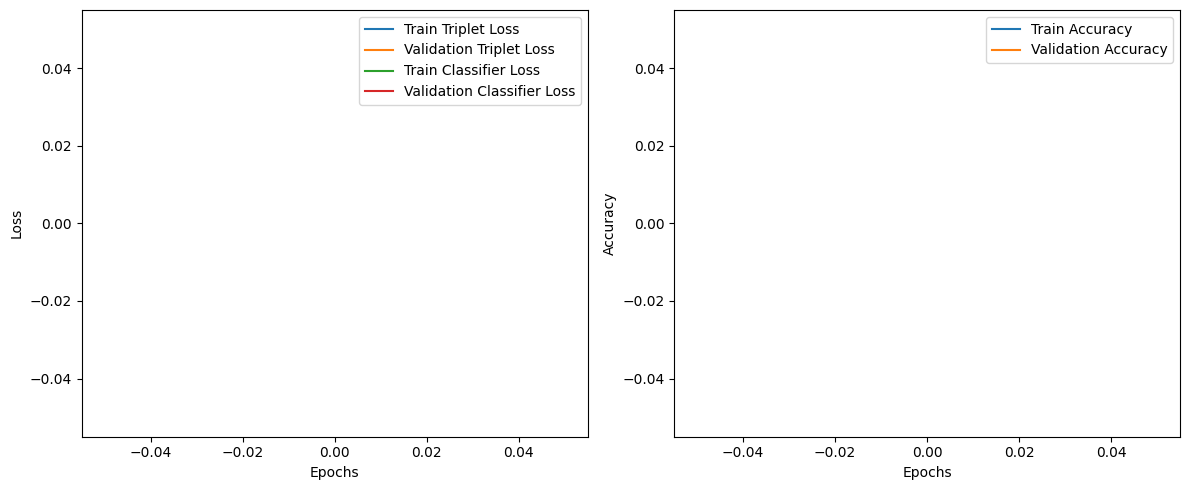

In [15]:
# Plotting the results
epochs = range(1, len(train_triplet_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_triplet_losses, label='Train Triplet Loss')
plt.plot(epochs, val_triplet_losses, label='Validation Triplet Loss')
plt.plot(epochs, train_classifier_losses, label='Train Classifier Loss')
plt.plot(epochs, val_classifier_losses, label='Validation Classifier Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
def embed_images_and_update_json(model, dataset, device, json_file):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    embeddings = []

    with torch.no_grad():
        for images, idxs in loader:
            images = images.to(device)
            embeddings_output = model(images, return_embedding=True).cpu().numpy().flatten()
            embeddings.append((idxs.item(), embeddings_output))

    # Update JSON file with embeddings
    with open(json_file, 'r+') as f:
        data = json.load(f)
        for idx, emb in embeddings:
            data[idx]['embedding'] = emb.tolist()
        f.seek(0)
        json.dump(data, f, indent=4)
        f.truncate()

model = CustomResNet50(num_classes=len(train_dataset.classes)).to(device)
# Load model weights
state_dict = torch.load('best_model.pth')
model.load_state_dict(state_dict)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Process training and validation data
train_json = '/workspaces/finetune/AFINAL/resnet/output/train_data.json'
val_json = '/workspaces/finetune/AFINAL/resnet/output/val_data.json'
test_json = '/workspaces/finetune/AFINAL/resnet/output/test_data.json'

train_dataset = CustomDataset(json_file=train_json, transform=transform)
val_dataset = CustomDataset(json_file=val_json, transform=transform)
test_dataset = CustomDataset(json_file=test_json, transform=transform)

embed_images_and_update_json(model, train_dataset, device, train_json)
embed_images_and_update_json(model, val_dataset, device, val_json)
embed_images_and_update_json(model, test_dataset, device, test_json)


In [26]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to load data from JSON file
def load_data(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

# Function to compute Top-K accuracy
def compute_top_k_accuracy(query_data, gallery_data, k):
    total_queries = len(query_data)
    top_k_hits = 0

    # Preparing the gallery embeddings and classes
    gallery_embeddings = np.array([item['embedding'] for item in gallery_data])
    gallery_classes = np.array([item['class'] for item in gallery_data])

    # Loop through each query image
    for query in query_data:
        query_embedding = np.array([query['embedding']])
        query_class = query['class']

        # Compute cosine similarities between this query and all gallery images
        similarities = cosine_similarity(query_embedding, gallery_embeddings)[0]

        # Get indices of the top K most similar images
        top_k_indices = np.argsort(similarities)[-k:]

        # Check if the correct class is within the top K similar images
        if query_class in gallery_classes[top_k_indices]:
            top_k_hits += 1

    # Calculate average Top-K accuracy
    top_k_accuracy = top_k_hits / total_queries
    return top_k_accuracy

# Load datasets
test_data = load_data('/workspaces/finetune/AFINAL/resnet/output/test_data.json')
val_data = load_data('/workspaces/finetune/AFINAL/resnet/output/val_data.json')
train_data = load_data('/workspaces/finetune/AFINAL/resnet/output/train_data.json')

# Combine validation and training data into one gallery set
gallery_data = val_data + train_data

# Set the value of K
k = 100  # Adjust based on your specific requirements

# Compute the Top-K accuracy
average_top_k_accuracy = compute_top_k_accuracy(test_data, gallery_data, k)
print(f"Average Top-{k} Accuracy: {average_top_k_accuracy:.2f}")



Average Top-100 Accuracy: 0.99


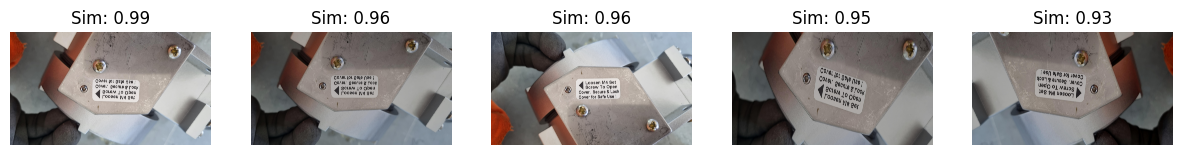

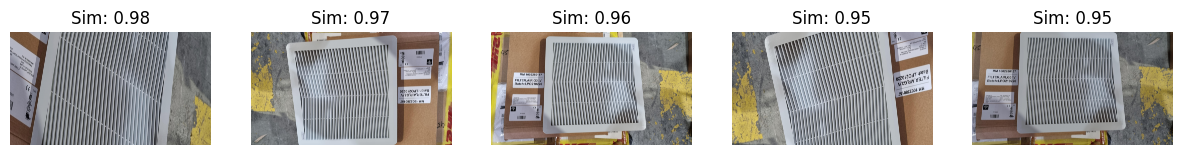

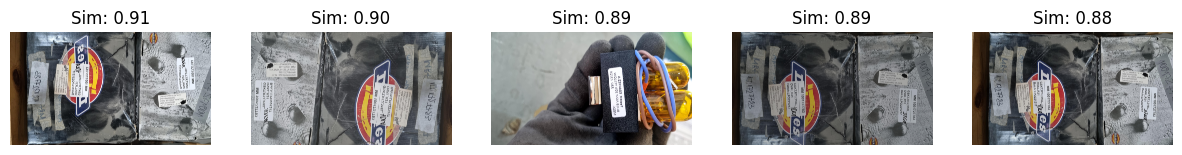

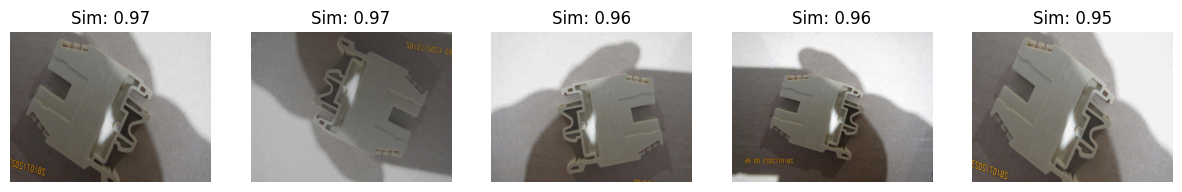

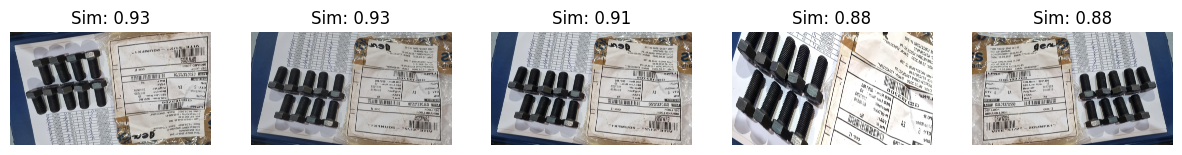

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import random

# Load data from JSON file
def load_data(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

# Display images with similarities
def display_similar_images(query_image, gallery_data, top_k=5):
    query_embedding = np.array(query_image['embedding'])
    gallery_embeddings = np.array([item['embedding'] for item in gallery_data])
    gallery_paths = [item['image_path'] for item in gallery_data]

    # Calculate cosine similarities and find top k indices
    similarities = cosine_similarity([query_embedding], gallery_embeddings)[0]
    top_k_indices = np.argsort(similarities)[-top_k:][::-1]

    fig, axs = plt.subplots(1, top_k, figsize=(15, 10))
    for i, idx in enumerate(top_k_indices):
        img_path = gallery_paths[idx]
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"Sim: {similarities[idx]:.2f}")

    plt.show()

# Load datasets
test_data = load_data('/workspaces/finetune/AFINAL/resnet/output/test_data.json')
gallery_data = load_data('/workspaces/finetune/AFINAL/resnet/output/val_data.json') + load_data('/workspaces/finetune/AFINAL/resnet/output/train_data.json')

# Randomly pick 5 query images from the test set
random_queries = random.sample(test_data, 5)

# Show the 5 most similar images for each random query image
for query in random_queries:
    display_similar_images(query, gallery_data)


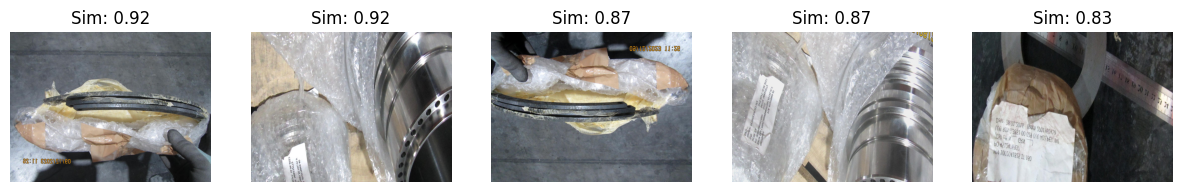

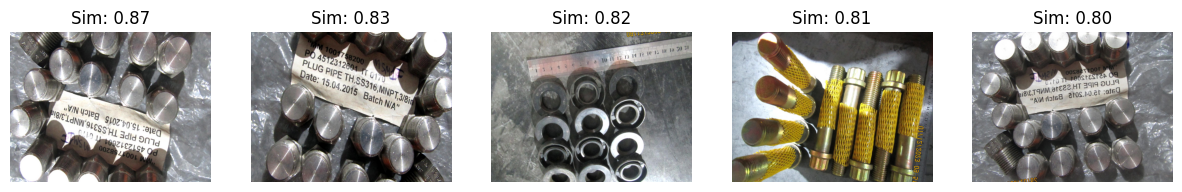

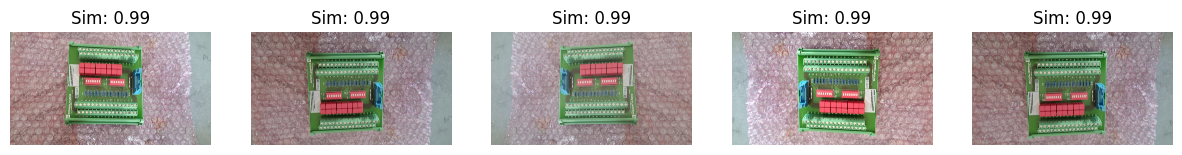

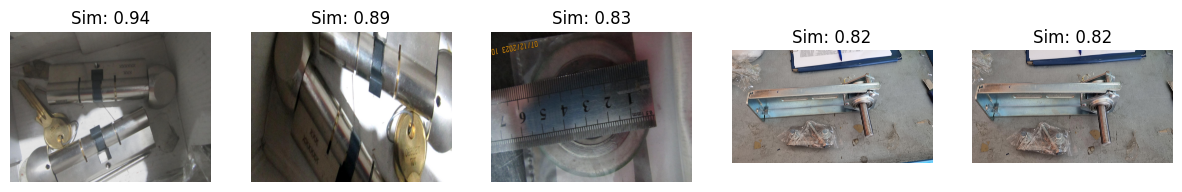

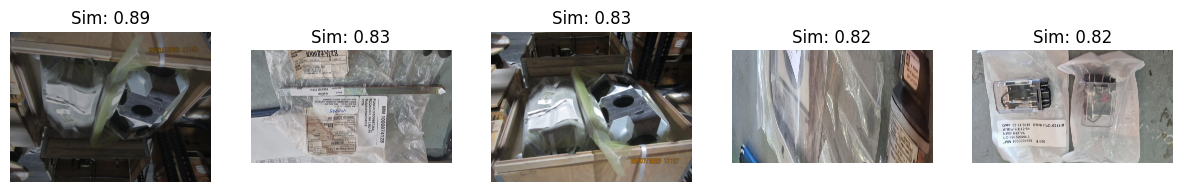

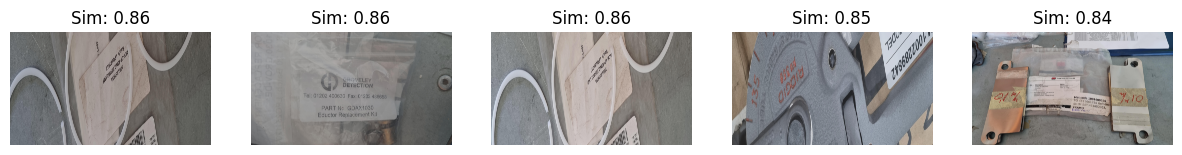

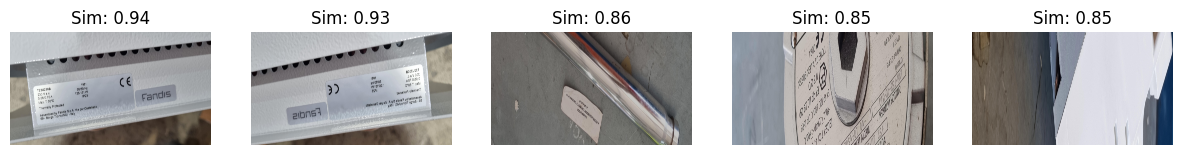

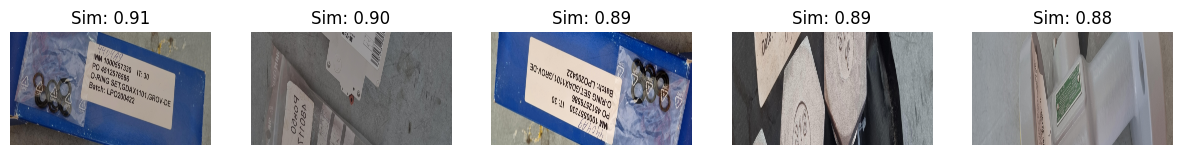

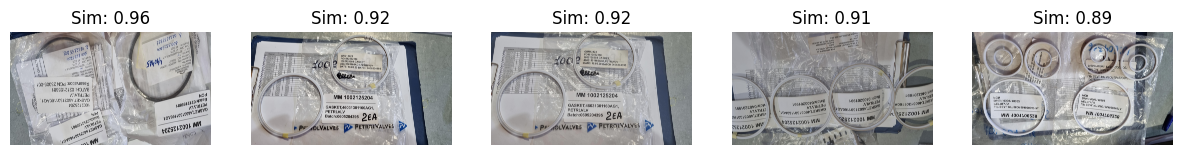

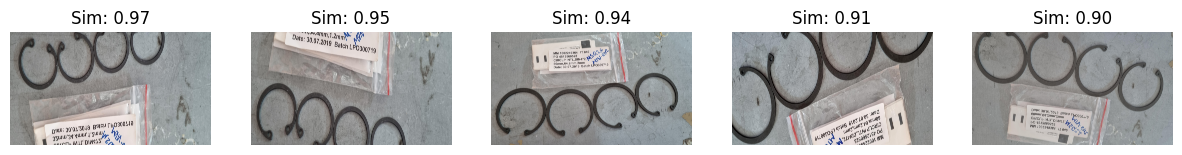

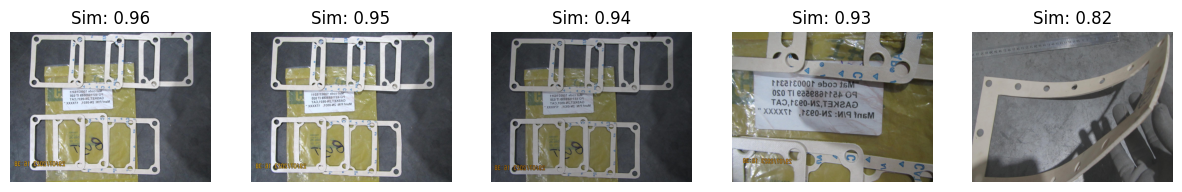

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import random

# Load data from JSON file
def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Prepare the query and gallery sets
def prepare_query_and_gallery(data):
    classes_seen = {}
    query_images = []
    gallery_images = []

    for item in data:
        class_id = item['class']
        if class_id not in classes_seen:
            classes_seen[class_id] = True
            query_images.append(item)
        else:
            gallery_images.append(item)
    
    # Ensure query images also appear in the gallery for other classes
    gallery_images.extend(query_images)
    return query_images, gallery_images

# Display images with similarities
def display_similar_images(query_image, gallery_data, top_k=5):
    query_embedding = np.array(query_image['embedding'])
    gallery_embeddings = np.array([item['embedding'] for item in gallery_data if item['image_path'] != query_image['image_path']])
    gallery_paths = [item['image_path'] for item in gallery_data if item['image_path'] != query_image['image_path']]

    # Calculate cosine similarities and find top k indices
    similarities = cosine_similarity([query_embedding], gallery_embeddings)[0]
    top_k_indices = np.argsort(similarities)[-top_k:][::-1]

    fig, axs = plt.subplots(1, top_k, figsize=(15, 10))
    for i, idx in enumerate(top_k_indices):
        img_path = gallery_paths[idx]
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"Sim: {similarities[idx]:.2f}")

    plt.show()

# Load test dataset
test_data = load_data('/workspaces/finetune/AFINAL/resnet/output/test_data.json')

# Prepare query and gallery sets
query_images, gallery_images = prepare_query_and_gallery(test_data)

# Display the 5 most similar images for each query image
for query in query_images:
    display_similar_images(query, gallery_images)
